<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, GRU
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Step 1: Mount Google Drive

drive.mount('/content/drive')

# Step 2: Clone the GitHub Repository
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git

# Step 3: Collect Paths and Labels

paths = []
labels = []

# Define the path to the dataset
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'

# Walk through the directory and collect file paths and labels
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        # Extract label from the filename
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

    # Break if we've collected a specified number of files, if needed
    # if len(paths) == 2800:  # Adjust this number as necessary
    #     break

print('Dataset is Loaded')


Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2839, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 2839 (delta 5), reused 6 (delta 0), pack-reused 2818
Receiving objects: 100% (2839/2839), 216.58 MiB | 14.49 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5602/5602), done.
Dataset is Loaded


In [3]:
len(paths)

5600

In [4]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_mode_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_lore_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_lid_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_shawl_disgust.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_disgust/YAF_shirt_disgust.wav']

In [5]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
1,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
2,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
3,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust
4,/content/SoundSense-Sentiment-Analysis/TESS To...,disgust


In [7]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [8]:
df['label'].value_counts()

label
disgust    800
ps         800
happy      800
neutral    800
fear       800
angry      800
sad        800
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

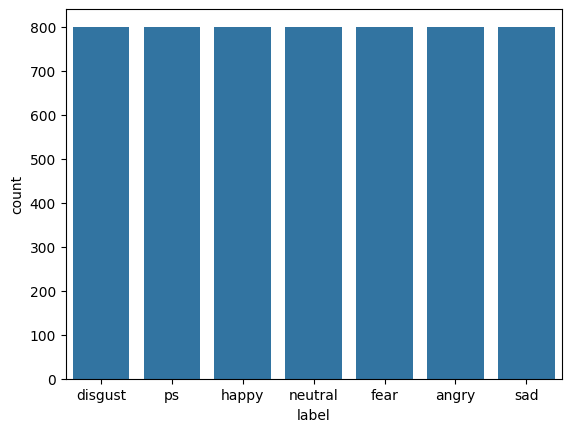

In [9]:
sns.countplot(data=df, x='label')

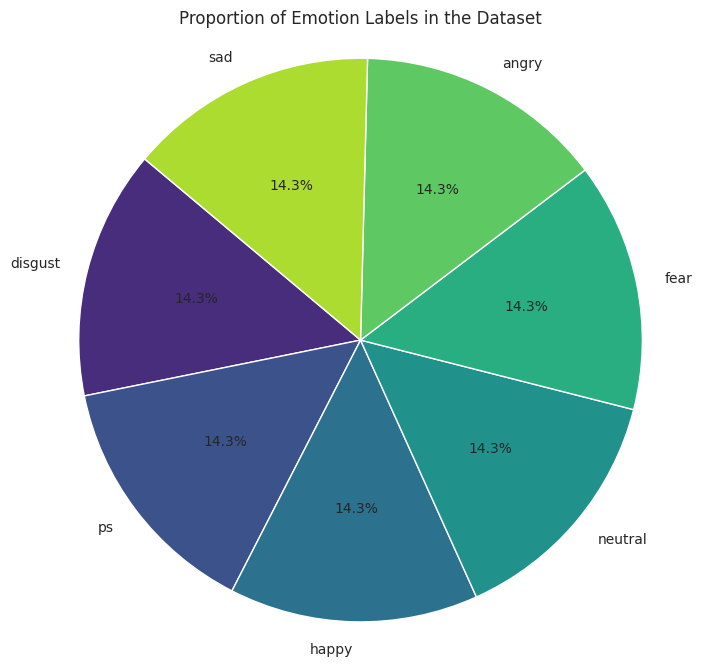

In [10]:
# Get label counts
label_counts = df['label'].value_counts()
# Data for the pie chart
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
# Set Seaborn style
sns.set_style("whitegrid")
# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [11]:
def plot_with_title(emotion, title, figsize=(10, 4), size=20):
    plt.figure(figsize=figsize)
    plt.title(f"{emotion}: {title}", fontsize=size, fontweight='bold', color='navy')

def waveplot(data, sr, emotion):
    plot_with_title(emotion, "Waveform")
    librosa.display.waveshow(data, sr=sr, color='dodgerblue', alpha=0.8, linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('Amplitude', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()

def mfcc(data, sr, emotion):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plot_with_title(emotion, "MFCCs", figsize=(10, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('MFCC Coefficients', fontsize=15, fontweight='bold', color='darkslategray')
    plt.tight_layout()
    plt.show()

def zero_crossing_rate(data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    plot_with_title(emotion, "Zero Crossing Rate", figsize=(10, 4))
    plt.plot(zcr[0], color='crimson')
    plt.xlabel('Frame', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('ZCR', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


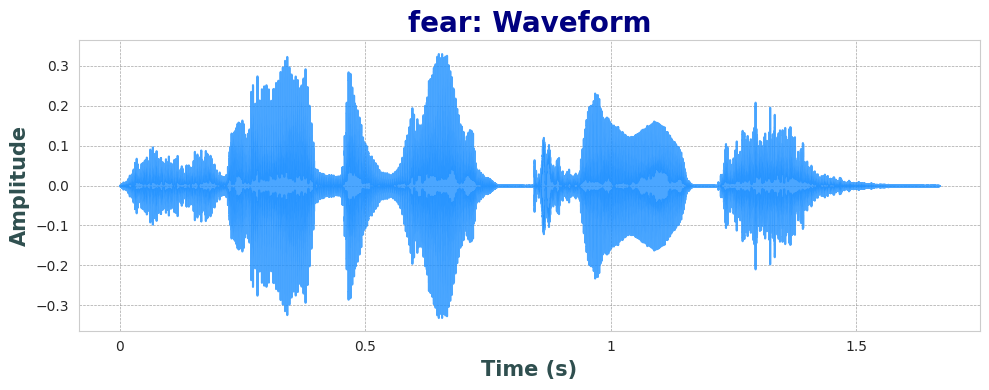

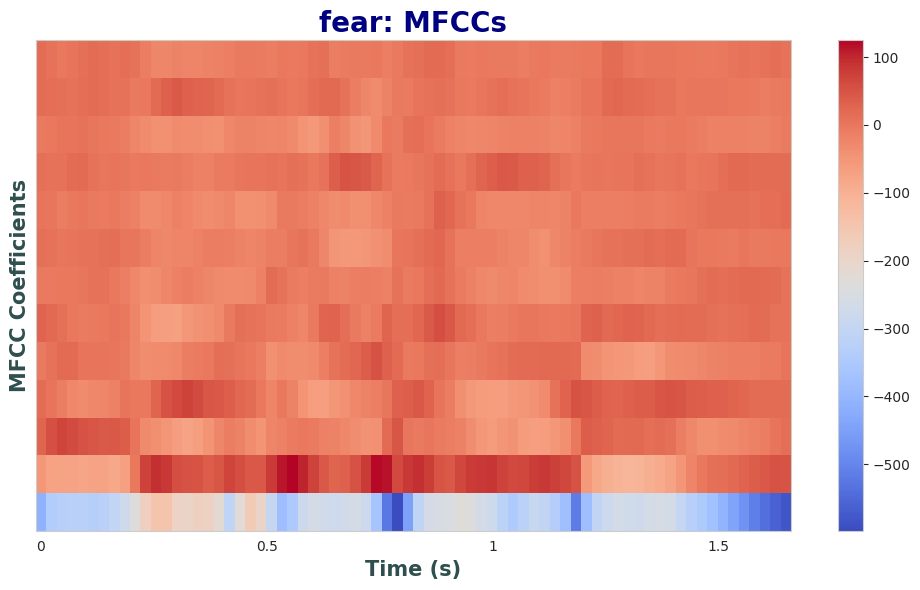

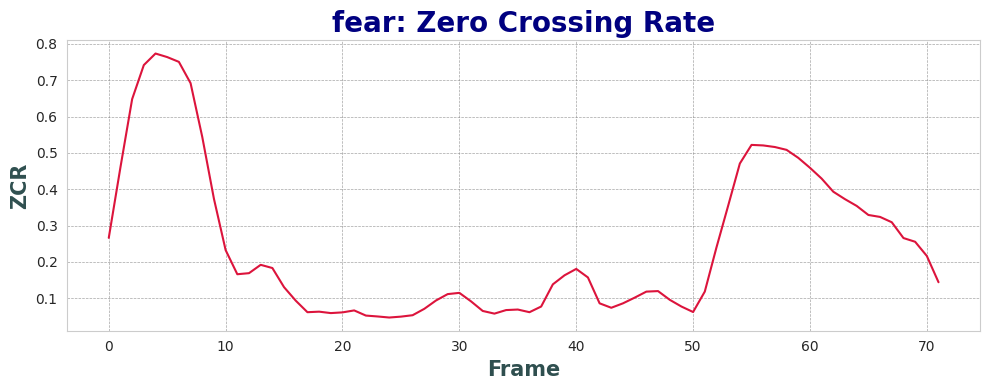

In [12]:
emotion = 'fear'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

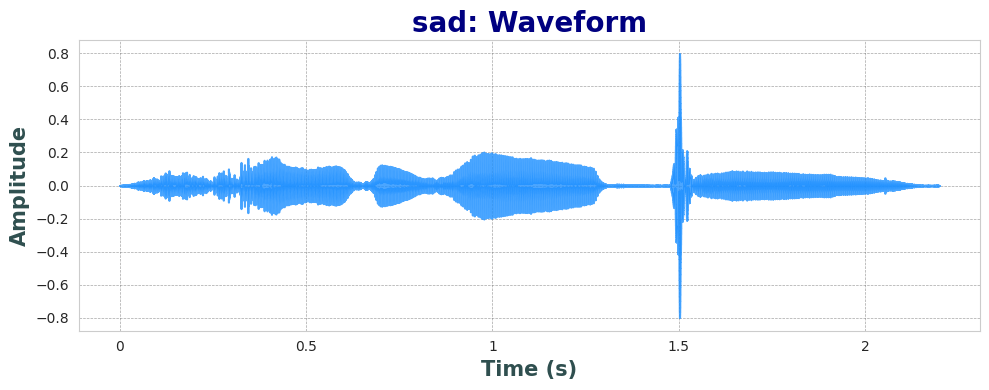

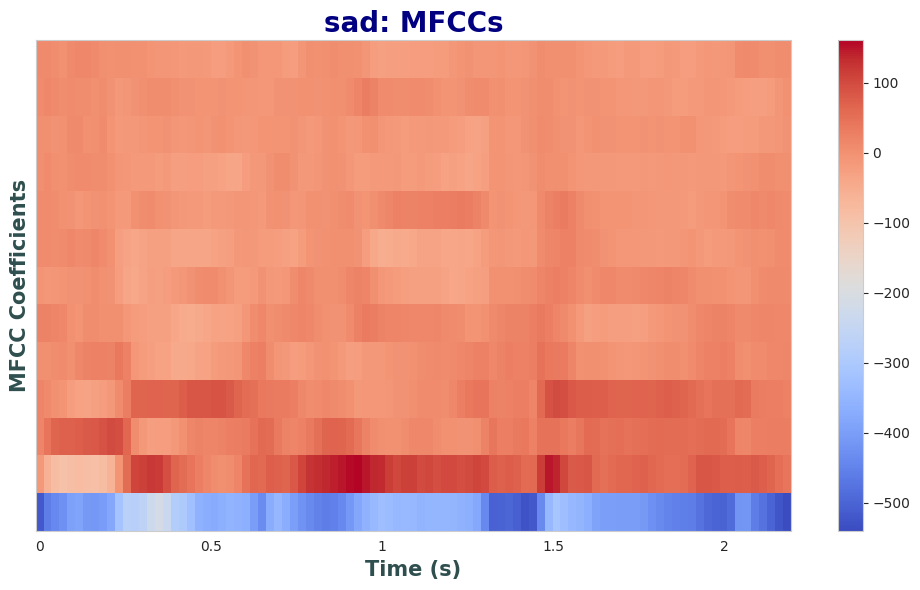

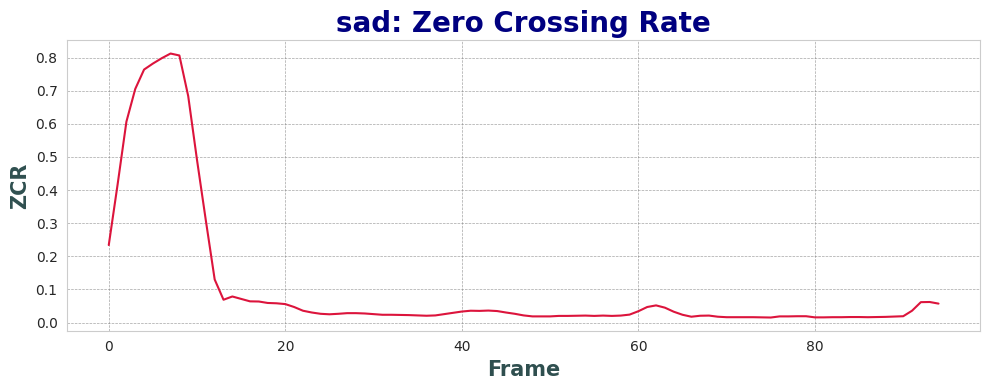

In [13]:
emotion = 'sad'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

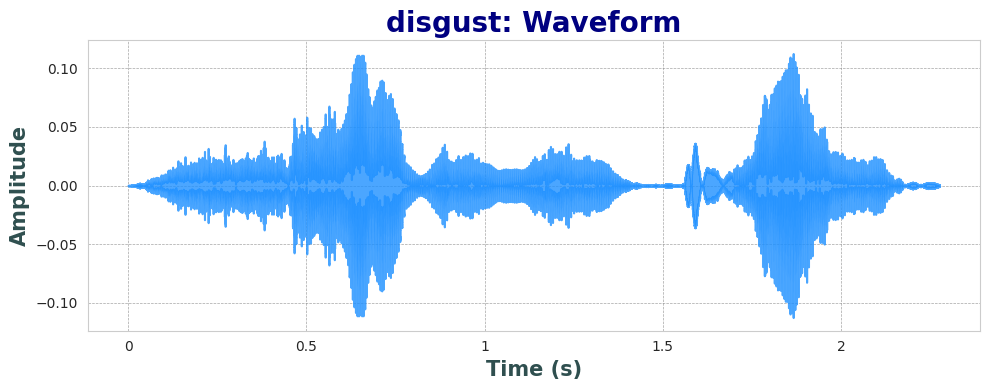

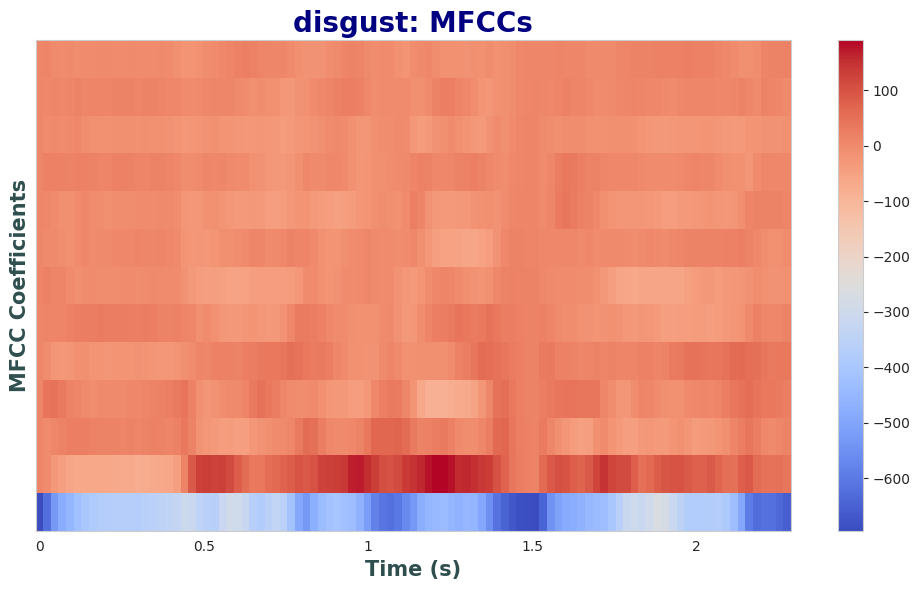

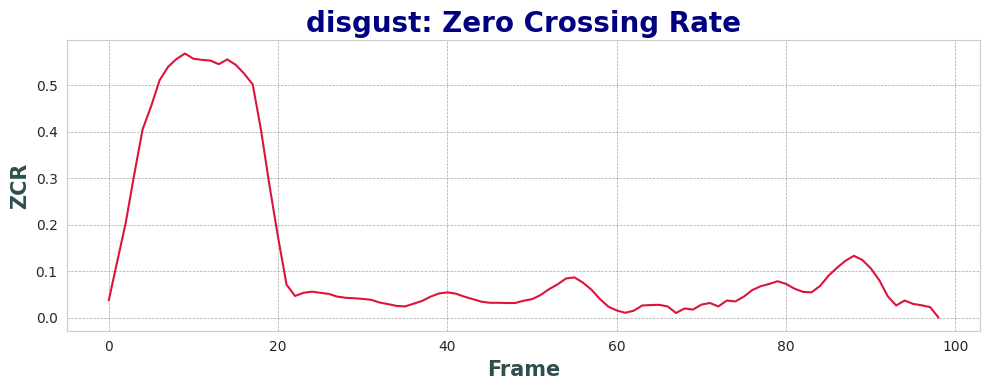

In [ ]:
emotion = 'disgust'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

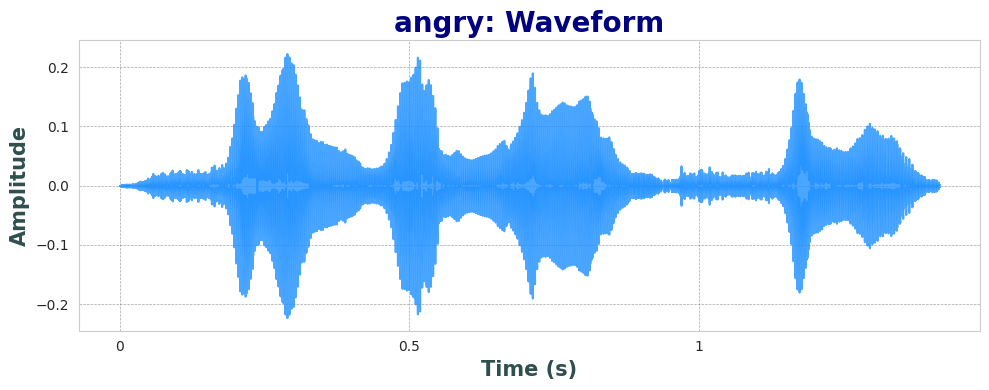

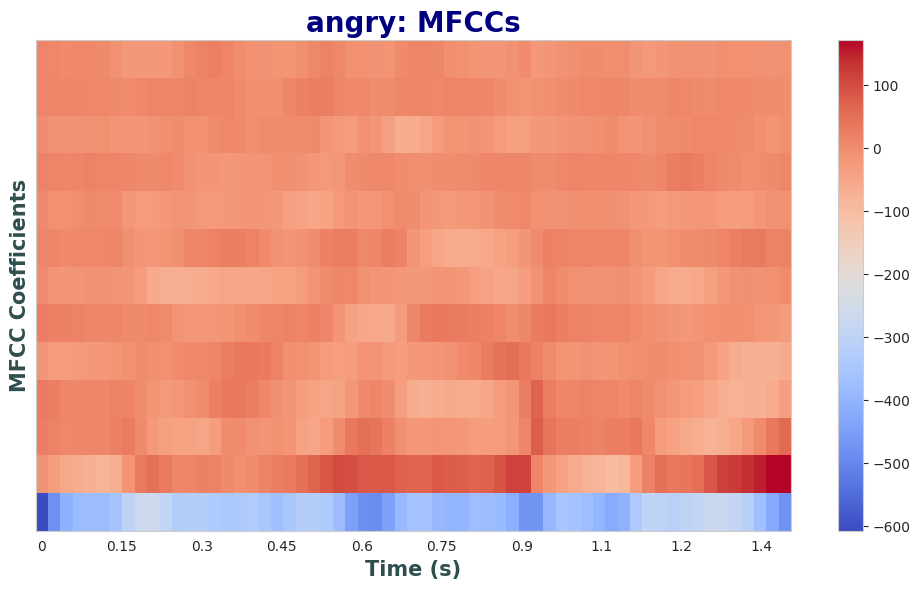

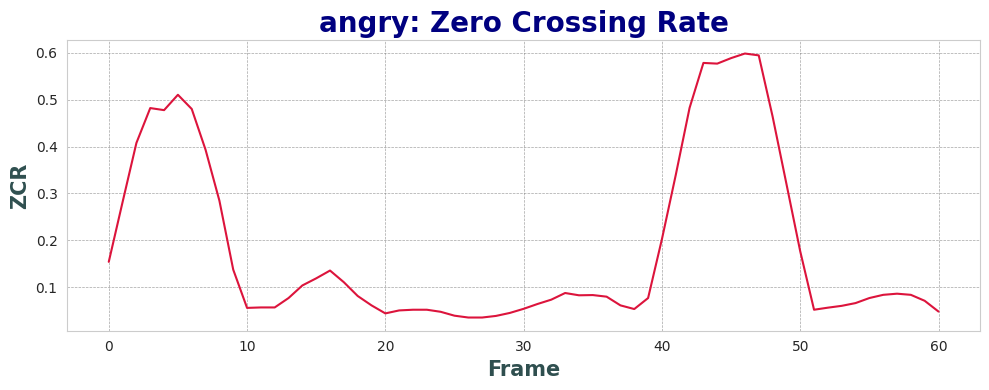

In [ ]:
emotion = 'angry'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

In [29]:
def extract_mfcc(filename, duration=3, offset=0.5, n_mfcc=40):
    """
    Extracts the mean Mel Frequency Cepstral Coefficients (MFCC) from an audio file.

    Parameters:
        filename (str): Path to the audio file.
        duration (float): Duration of the audio to be loaded (in seconds). Default is 3 seconds.
        offset (float): Start reading after this time (in seconds). Default is 0.5 seconds.
        n_mfcc (int): Number of MFCCs to extract. Default is 40.

    Returns:
        np.ndarray: Array containing the mean MFCC values.
    """
    try:
        # Load the audio file
        audio_data, sample_rate = librosa.load(filename, duration=duration, offset=offset)

        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

        # Calculate the mean MFCC across time
        mean_mfcc = np.mean(mfcc_features.T, axis=0)

        return mean_mfcc

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

In [30]:
def get_mfcc_features(speech):
    return extract_mfcc(speech)

In [31]:
# Extract MFCC features for all speech samples in the dataframe
X_mfcc = df['speech'].apply(get_mfcc_features)

In [32]:
# Convert the list of MFCC feature arrays into a numpy array
X = np.array([x for x in X_mfcc])

# Check the shape of the resulting feature array
print(X.shape)

(5600, 40)


In [33]:
# Expand dimensions to match the expected input shape for neural networks
X = np.expand_dims(X, -1)

# Check the shape after expanding dimensions
print(X.shape)

(5600, 40, 1)


In [34]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

# Check the shape of the encoded labels
print(y.shape)

(5600, 7)


In [35]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting training and validation sets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4480, 40, 1) (1120, 40, 1) (4480, 7) (1120, 7)


In [ ]:
from keras import layers
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 128)            0

In [ ]:
import tensorflow as tf
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
70/70 [==============================] - 14s 168ms/step - loss: 2.2638 - accuracy: 0.2301 - val_loss: 1.4468 - val_accuracy: 0.3098
Epoch 2/50
70/70 [==============================] - 11s 162ms/step - loss: 1.4906 - accuracy: 0.3596 - val_loss: 1.3687 - val_accuracy: 0.4313
Epoch 3/50
70/70 [==============================] - 9s 131ms/step - loss: 1.4093 - accuracy: 0.4127 - val_loss: 1.3561 - val_accuracy: 0.4420
Epoch 4/50
70/70 [==============================] - 12s 166ms/step - loss: 1.3785 - accuracy: 0.4121 - val_loss: 1.3205 - val_accuracy: 0.4357
Epoch 5/50
70/70 [==============================] - 12s 167ms/step - loss: 1.3595 - accuracy: 0.4152 - val_loss: 1.3038 - val_accuracy: 0.4411
Epoch 6/50
70/70 [==============================] - 11s 155ms/step - loss: 1.3324 - accuracy: 0.4217 - val_loss: 1.2895 - val_accuracy: 0.4411
Epoch 7/50
70/70 [==============================] - 10s 149ms/step - loss: 1.3156 - accuracy: 0.4156 - val_loss: 1.2766 - val_accuracy: 0.4277


In [ ]:
model1 = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 7)                

In [ ]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
70/70 [==============================] - 16s 198ms/step - loss: 0.8248 - accuracy: 0.6900 - val_loss: 0.2255 - val_accuracy: 0.9098
Epoch 2/50
70/70 [==============================] - 14s 195ms/step - loss: 0.2271 - accuracy: 0.9239 - val_loss: 0.1295 - val_accuracy: 0.9536
Epoch 3/50
70/70 [==============================] - 13s 190ms/step - loss: 0.1516 - accuracy: 0.9540 - val_loss: 0.0651 - val_accuracy: 0.9812
Epoch 4/50
70/70 [==============================] - 13s 177ms/step - loss: 0.1035 - accuracy: 0.9670 - val_loss: 0.1301 - val_accuracy: 0.9580
Epoch 5/50
70/70 [==============================] - 13s 189ms/step - loss: 0.1255 - accuracy: 0.9632 - val_loss: 0.0599 - val_accuracy: 0.9804
Epoch 6/50
70/70 [==============================] - 14s 196ms/step - loss: 0.0852 - accuracy: 0.9725 - val_loss: 0.0521 - val_accuracy: 0.9795
Epoch 7/50
70/70 [==============================] - 14s 197ms/step - loss: 0.0680 - accuracy: 0.9777 - val_loss: 0.0791 - val_accuracy: 0.9750

In [36]:
model2 = Sequential([
    GRU(123, return_sequences = False, input_shape = (40, 1)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')

])

model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 123)               46494     
                                                                 
 dense_3 (Dense)             (None, 64)                7936      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 56741 (221.64 KB)
Trainable params: 5674

In [37]:
#Training the model
history = model2.fit(X, y, validation_split = 0.2, epochs = 100, batch_size = 512, shuffle = True)

Epoch 1/100
9/9 [==============================] - 9s 502ms/step - loss: 1.9042 - accuracy: 0.2536 - val_loss: 1.8380 - val_accuracy: 0.2741
Epoch 2/100
9/9 [==============================] - 2s 248ms/step - loss: 1.7009 - accuracy: 0.3589 - val_loss: 1.6354 - val_accuracy: 0.2321
Epoch 3/100
9/9 [==============================] - 3s 329ms/step - loss: 1.4968 - accuracy: 0.4092 - val_loss: 1.4192 - val_accuracy: 0.3134
Epoch 4/100
9/9 [==============================] - 4s 439ms/step - loss: 1.2642 - accuracy: 0.4788 - val_loss: 1.4098 - val_accuracy: 0.4473
Epoch 5/100
9/9 [==============================] - 2s 246ms/step - loss: 1.0608 - accuracy: 0.5853 - val_loss: 1.1856 - val_accuracy: 0.5080
Epoch 6/100
9/9 [==============================] - 2s 234ms/step - loss: 0.8470 - accuracy: 0.6835 - val_loss: 0.8042 - val_accuracy: 0.6491
Epoch 7/100
9/9 [==============================] - 2s 248ms/step - loss: 0.6989 - accuracy: 0.7317 - val_loss: 0.7449 - val_accuracy: 0.7179
Epoch 8/100
9

In [41]:
# Extract MFCC features for all speech samples in the dataframe
X_mfcc = df['speech'].apply(extract_mfcc)
# Convert the list of MFCC feature arrays into a numpy array
X = np.array([x for x in X_mfcc])

In [42]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [43]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

In [44]:
# Convert one-hot encoded labels back to single label for SVM
y_labels = np.argmax(y, axis=1)
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_labels, test_size=0.2, random_state=42)

In [45]:
# Train SVM model
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [46]:
# Evaluate the model
y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=encoder.categories_[0])
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.9964285714285714
Classification Report:
               precision    recall  f1-score   support

       angry       0.99      0.99      0.99       163
     disgust       0.99      1.00      1.00       163
        fear       1.00      1.00      1.00       158
       happy       0.99      0.99      0.99       165
     neutral       1.00      1.00      1.00       162
          ps       1.00      0.99      1.00       153
         sad       1.00      1.00      1.00       156

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120

